## 正常YOLOv11实验

In [1]:
import os
from pathlib import Path

cur_file_dir = Path(os.getcwd())

data_dir = cur_file_dir.parent / "data" / "origin"

def rename_df_columns(df, mapping=None, case=None, prefix='', suffix='', replace_spaces=None, strip=True, inplace=False):
    """
    Rename dataframe columns with small utilities.
    - mapping: dict old_name -> new_name (applied before other transforms)
    - case: 'lower' or 'upper' or None
    - prefix/suffix: strings added to every column name
    - replace_spaces: None or string to replace spaces with (e.g. '_')
    - strip: whether to strip whitespace from column names
    - inplace: if True modifies df in-place and returns None, else returns new df
    """
    if not inplace:
        df = df.copy()
    cols = df.columns.tolist()
    new_cols = []
    for c in cols:
        new = c
        if strip and isinstance(new, str):
            new = new.strip()
        if mapping and c in mapping:
            new = mapping[c]
        if replace_spaces and isinstance(new, str):
            new = new.replace(' ', replace_spaces)
        if case == 'lower' and isinstance(new, str):
            new = new.lower()
        elif case == 'upper' and isinstance(new, str):
            new = new.upper()
        new = f"{prefix}{new}{suffix}"
        new_cols.append(new)
    df.columns = new_cols
    return None if inplace else df

def replace_in_columns(df, replacements, regex=False, inplace=False):
    """
    Replace specific values in specified columns.
    - replacements: dict where keys are column names and values are either:
         * dict(old_value -> new_value, ...)
         * list/tuple of (pattern, repl) pairs
         * scalar/Series/list accepted by pandas.Series.replace
    - regex: passed to pandas.Series.replace (useful when patterns are regex)
    - inplace: if True modifies df in-place and returns None, else returns new df
    Example:
        replace_in_columns(df, {'model': {'yolo11x': 'yolov11x', 'yolo11m': 'yolov11m'}})
    """
    if not inplace:
        df = df.copy()
    for col, repl in replacements.items():
        if col not in df.columns:
            continue
        # Use pandas replace which accepts dict, list of pairs, regex flag, etc.
        df[col] = df[col].replace(repl, regex=regex)
    return None if inplace else df


def bold_best_in_groups(df, groupby, columns, mode='max', fmt='{:.2f}', latex=True):
    """
    Wrap the best value(s) in each group with LaTeX \\textbf{...} (or markdown **...**).
    - df: pandas.DataFrame
    - groupby: list of column names to group by
    - columns: list of column names to consider for bolding
    - mode: 'max' or 'min' (which value is considered better)
    - fmt: format string for numeric values (used before wrapping)
    - latex: if True use LaTeX \\textbf{...}, else use Markdown **...**
    Returns a copy of df with selected cells converted to strings and bolded.
    """
    import pandas as pd
    import numpy as np

    out = df.copy()
    # operate on display column names (they may be already renamed)
    for _, group in out.groupby(groupby, sort=False):
        # group is a view of out with original index preserved
        for col in columns:
            if col not in out.columns:
                continue
            # try to coerce to numeric to decide best; preserve original values for formatting
            vals = pd.to_numeric(group[col], errors='coerce')
            if vals.dropna().empty:
                continue
            if mode == 'max':
                best_mask = vals == vals.max()
            else:
                best_mask = vals == vals.min()
            # iterate indices where best_mask True
            for idx, is_best in best_mask.items():
                if not is_best:
                    continue
                orig_val = group.at[idx, col]
                # format numeric values, leave others as str
                if isinstance(orig_val, (int, float, np.floating, np.integer)) or pd.api.types.is_numeric_dtype(type(orig_val)):
                    try:
                        formatted = fmt.format(orig_val)
                    except Exception:
                        # fallback
                        formatted = str(orig_val)
                else:
                    formatted = str(orig_val)
                if latex:
                    out.at[idx, col] = r'\textbf{' + formatted + '}'
                else:
                    out.at[idx, col] = '**' + formatted + '**'
    return out

def reformat_df(df, bold_cfgs=None):
    filtered_df = df[~df['method'].isin(['pgd', 'square_attack'])]
    filtered_df['model'] = filtered_df['model'].replace('yolo11x', 'yolov9x')
    filtered_df['model'] = filtered_df['model'].replace('yolo11m', 'yolov9m')
    filtered_df = filtered_df.sort_values(by=['model', 'epsilon', 'method'])
    # change model yolo11x to yolov11
    filtered_df['model'] = filtered_df['model'].replace('yolov9x', 'yolov11x')
    filtered_df['model'] = filtered_df['model'].replace('yolov9m', 'yolov11m')
    rename_col_map = {
        'epsilon': r'$\varepsilon$',
        '0.5 delta pgd' : r'${\tau=0.5}$',
        '0.7 delta pgd' : r'${\tau=0.7}$',
    }
    replace_col_map = {
        'model': {
            'yolov11x': 'v11x',
            'yolov11m': 'v11m',
            'yolov8x': 'v8x',
            'yolov8m': 'v8m',
            'yolov5xu': 'v5x',
            'yolov5mu': 'v5m',
            'yolov3-sppu': 'v3spp',
            'yolov3u': 'v3',
        },
        'method': {
            'rcp' : r'$\mathrm{RCP}_N$',
            'odpv': r'Ours'
        },
        r'$\varepsilon$': {
            '1/255' : r'$\frac{1}{255}$',
            '2/255' : r'$\frac{2}{255}$',
            '4/255' : r'$\frac{4}{255}$',
            '8/255' : r'$\frac{8}{255}$',
        }
    }
    filtered_df = rename_df_columns(filtered_df, mapping=rename_col_map, inplace=False)
    filtered_df = replace_in_columns(filtered_df, replacements=replace_col_map, inplace=False)

    # bold_cfg example:
    # bold_cfg = {
    #   'groupby': [r'$\varepsilon$'],           # group key(s) after renaming
    #   'columns': [r'${\tau=0.5}$', r'${\tau=0.7}$'],  # columns to bold
    #   'mode': 'min',                            # 'min' or 'max' (which is "better")
    #   'fmt': '{:.2f}',
    #   'latex': True
    # }
    if bold_cfgs:
        for bold_cfg in bold_cfgs:
            gb = bold_cfg.get('groupby')
            cols = bold_cfg.get('columns')
            mode = bold_cfg.get('mode', 'max')
            fmt = bold_cfg.get('fmt', '{:.2f}')
            latex = bold_cfg.get('latex', True)
            if gb and cols:
                filtered_df = bold_best_in_groups(filtered_df, groupby=gb, columns=cols, mode=mode, fmt=fmt, latex=latex)

    return filtered_df

overview_header = r"\multirow{2}{*}{$\varepsilon$} & \multirow{2}{*}{method} & \multirow{2}{*}{model} & \multirow{2}{*}{time} & \multicolumn{2}{c|}{$\Delta_{\mathrm{PGD}}$} & \multirow{2}{*}{model} & \multirow{2}{*}{time} & \multicolumn{2}{c}{$\Delta_{\mathrm{PGD}}$} \\ \cline{5-6} \cline{9-10} & & & & {\small$\tau=0.5$} & {\small$\tau=0.7$} & & & {\small$\tau=0.5$} & {\small$\tau=0.7$} \\"
overview_col_format = r"c|l|c|r|cc|c|r|ccc"


bold_cfgs = [{
  'groupby': [r'$\varepsilon$', 'model'],           # group key(s) after renaming
  'columns': [r'${\tau=0.5}$', r'${\tau=0.7}$'],  # columns to bold
  'mode': 'min',                            # 'min' or 'max' (which is "better")
  'fmt': '{:.2f}',
  'latex': True
},
{
  'groupby': [r'$\varepsilon$', 'model'],           # group key(s) after renaming
  'columns': ['time'],  # columns to bold
  'mode': 'min',                            # 'min' or 'max' (which is "better")
  'fmt': '{:.1f}',
  'latex': True
}]

from common_utils import change_to_2_col, df_to_latex_multirow2


### 实验一：整体效果

In [2]:
target_csv = data_dir /  "full_results_processed.csv"
# csv title: model,image,gt_index,epsilon,conf_threshold,iou_threshold,method,iou,iou_0.5,iou_0.7,time
import pandas as pd
import numpy as np


# 读取 CSV 文件
df = pd.read_csv(target_csv)

# 获取 PGD 方法的数据作为基准
pgd_data = df[df['method'] == 'pgd'].copy()

# 创建结果列表
results = []


def get_full_results_df(df, select_methods=['rcp', 'odpv'], target_method='pgd'):
    results = []
    for (model,epsilon, method), group in df.groupby(['model','epsilon','method'], sort=False):
        if method not in select_methods:
            continue
        target_df = group[(group['target_method'] == target_method)]
        if target_df.empty:
            continue
        time = target_df['time'].mean()
        delta_07 = target_df['delta_0.7'].mean()
        delta_05 = target_df['delta_0.5'].mean()
        results.append({
            'model': model,
            'epsilon': epsilon,
            'method': method,
            'time': time,
            f'0.5 delta {target_method}': delta_05,
            f'0.7 delta {target_method}': delta_07,
        })
    results_df = pd.DataFrame(results)
    return results_df
tmp_df = pd.read_csv(target_csv)
results = get_full_results_df(tmp_df)
# 转换为 DataFrame
result_df = pd.DataFrame(results)


filtered_df = reformat_df(result_df, bold_cfgs=bold_cfgs)
# 转换为 Markdown 表格
def to_markdown_table(df):
    # 创建表头
    headers = df.columns.tolist()
    header_line = "| " + " | ".join(headers) + " |"
    separator_line = "| " + " | ".join(["---"] * len(headers)) + " |"
    
    # 创建数据行
    rows = []
    for _, row in df.iterrows():
        formatted_row = []
        for col in headers:
            if col in ['time', '0.5 delta pgd', '0.7 delta pgd']:
                # 格式化数字为两位小数
                if isinstance(row[col], str) and (row[col].startswith(r'\textbf{') or row[col].startswith('**')):
                    # already formatted and bolded
                    formatted_row.append(row[col])
                else:
                    formatted_row.append(f"{row[col]:.2f}")
            else:
                formatted_row.append(str(row[col]))
        rows.append("| " + " | ".join(formatted_row) + " |")
    
    # 组合表格
    table = [header_line, separator_line] + rows
    return "\n".join(table)

# 输出 Markdown 表格
markdown_table = to_markdown_table(filtered_df)
print(markdown_table)



new_df = change_to_2_col(filtered_df)
cols_to_keep_indices = [ 1, 2, 0, 3, 4, 5, 6, 9, 10, 11]
new_df = new_df.iloc[:, cols_to_keep_indices]
# print(new_df)
latex = df_to_latex_multirow2(new_df, columns_to_merge=[r'$\varepsilon$', 'model'], header_str=overview_header, col_format_str=overview_col_format)
output_file = data_dir.parent / "overview.tex"
with open(output_file, 'w') as f:
    f.write(latex)

| model | $\varepsilon$ | method | time | ${\tau=0.5}$ | ${\tau=0.7}$ |
| --- | --- | --- | --- | --- | --- |
| v3spp | $\frac{1}{255}$ | Ours | \textbf{109.0} | \textbf{0.49} | \textbf{0.45} |
| v3spp | $\frac{1}{255}$ | $\mathrm{RCP}_N$ | 563.49 | 0.5470755670976843 | 0.5332016775721495 |
| v3spp | $\frac{2}{255}$ | Ours | \textbf{106.3} | \textbf{0.48} | \textbf{0.41} |
| v3spp | $\frac{2}{255}$ | $\mathrm{RCP}_N$ | 562.88 | 0.583068236952648 | 0.541494582546279 |
| v3 | $\frac{1}{255}$ | Ours | \textbf{108.5} | \textbf{0.52} | \textbf{0.46} |
| v3 | $\frac{1}{255}$ | $\mathrm{RCP}_N$ | 560.98 | 0.5746538330678954 | 0.5464100523883965 |
| v3 | $\frac{2}{255}$ | Ours | \textbf{105.0} | \textbf{0.48} | \textbf{0.42} |
| v3 | $\frac{2}{255}$ | $\mathrm{RCP}_N$ | 560.28 | 0.5952228491119961 | 0.5528653137158412 |
| v5m | $\frac{1}{255}$ | Ours | \textbf{43.6} | \textbf{0.42} | \textbf{0.39} |
| v5m | $\frac{1}{255}$ | $\mathrm{RCP}_N$ | 445.49 | 0.4705855097626744 | 0.4705517533285266 |

C:\Users\z8701\AppData\Local\Temp\ipykernel_9164\474769635.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.49}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.at[idx, col] = r'\textbf{' + formatted + '}'
C:\Users\z8701\AppData\Local\Temp\ipykernel_9164\474769635.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.45}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.at[idx, col] = r'\textbf{' + formatted + '}'
C:\Users\z8701\AppData\Local\Temp\ipykernel_9164\474769635.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{109.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype firs

### TPR/FPR with pgd

In [4]:
import pandas as pd

def calculate_all_metrics(df, method, gt_method, threshold):
    """
    根据给定的方法、基准方法和 IoU 阈值计算各种分类指标。

    参数:
        df (pd.DataFrame): 包含特定 model 和 epsilon 组合的透视后数据。
        method (str): 要评估的方法的名称。
        gt_method (str): 基准真值方法的名称。
        threshold (float): IoU 阈值。

    返回:
        dict: 包含所有计算指标的字典。
    """
    # 计算基础指标
    tp = ((df[method] > threshold) & (df[gt_method] > threshold)).sum()
    fp = ((df[method] > threshold) & (df[gt_method] <= threshold)).sum()
    tn = ((df[method] <= threshold) & (df[gt_method] <= threshold)).sum()
    fn = ((df[method] <= threshold) & (df[gt_method] > threshold)).sum()

    # 计算衍生指标，处理分母为零的情况
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

    return {
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
        'TPR': tpr, 'FPR': fpr, 'TNR': tnr, 'FNR': fnr
    }

# 加载数据集
try:
    df = pd.read_csv('../data/origin/full_results.csv')

    # --- 更新点 1: 在透视时加入 'epsilon' ---
    pivot_df = df.pivot_table(
        index=['model', 'image', 'gt_index', 'epsilon'],
        columns='method',
        values='iou'
    ).reset_index()

    # 定义要评估的场景
    methods_to_evaluate = ['odpv', 'rcp']
    ground_truths = ['square_attack', 'pgd']
    thresholds = [0.5, 0.7]

    # --- 更新点 2: 按 'model' 和 'epsilon' 分组计算 ---
    grouped = pivot_df.groupby(['model', 'epsilon'])

    final_results = []

    for (model, epsilon), group_df in grouped:
        for method in methods_to_evaluate:
            for gt in ground_truths:
                for threshold in thresholds:
                    # 确保评估的列存在
                    if method in group_df.columns and gt in group_df.columns:
                        metrics = calculate_all_metrics(group_df, method, gt, threshold)
                        result_row = {
                            'model': model,
                            'epsilon': epsilon,
                            'method': method,
                            'ground_truth': gt,
                            'iou_threshold': threshold,
                            **metrics  # 将计算出的指标字典合并进来
                        }
                        final_results.append(result_row)

    # --- 更新点 3: 将结果转换为 DataFrame 并展示 ---
    results_df = pd.DataFrame(final_results)

    # 打印结果或保存到文件
    # 为了更好地显示，设置 pandas 的显示选项
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.width', 120)
    print("各模型和 Epsilon 下的详细评估指标:")
    results_df.sort_values(by=['model', 'epsilon', 'ground_truth', 'iou_threshold', 'method'], inplace=True)
    col_order = ['model', 'epsilon', 'ground_truth', 'iou_threshold', 'method', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR', 'FNR']
    results_df = results_df[col_order]
    select_model = [
        'yolo11x', 'yolov8x', 'yolov5xu'
    ]
    results_df = results_df[results_df['model'].isin(select_model)]
    results_df = results_df[(results_df['ground_truth'] == 'pgd') & (results_df['iou_threshold'] == 0.5)]
    print(results_df)


except FileNotFoundError:
    print("错误: 'full_results.csv' 文件未找到。请确保文件与脚本在同一个目录下。")
except Exception as e:
    print(f"处理过程中发生错误: {e}")

各模型和 Epsilon 下的详细评估指标:
        model epsilon ground_truth  iou_threshold method  TP   FP   TN  FN       TPR       FPR       TNR       FNR
18    yolo11x   1/255          pgd            0.5   odpv  74  300  153   0  1.000000  0.662252  0.337748  0.000000
22    yolo11x   1/255          pgd            0.5    rcp  74  316  137   0  1.000000  0.697572  0.302428  0.000000
26    yolo11x   2/255          pgd            0.5   odpv   2  323  202   0  1.000000  0.615238  0.384762  0.000000
30    yolo11x   2/255          pgd            0.5    rcp   2  377  148   0  1.000000  0.718095  0.281905  0.000000
82   yolov5xu   1/255          pgd            0.5   odpv  74  294  159   0  1.000000  0.649007  0.350993  0.000000
86   yolov5xu   1/255          pgd            0.5    rcp  74  313  140   0  1.000000  0.690949  0.309051  0.000000
90   yolov5xu   2/255          pgd            0.5   odpv   6  332  189   0  1.000000  0.637236  0.362764  0.000000
94   yolov5xu   2/255          pgd            0.5    rcp 

### TPR/FPR with rcp

In [6]:
import pandas as pd

def calculate_all_metrics(df, method, gt_method, threshold):
    """
    根据给定的方法、基准方法和 IoU 阈值计算各种分类指标。

    参数:
        df (pd.DataFrame): 包含特定 model 和 epsilon 组合的透视后数据。
        method (str): 要评估的方法的名称。
        gt_method (str): 基准真值方法的名称。
        threshold (float): IoU 阈值。

    返回:
        dict: 包含所有计算指标的字典。
    """
    # 计算基础指标
    tp = ((df[method] > threshold) & (df[gt_method] > threshold)).sum()
    fp = ((df[method] > threshold) & (df[gt_method] <= threshold)).sum()
    tn = ((df[method] <= threshold) & (df[gt_method] <= threshold)).sum()
    fn = ((df[method] <= threshold) & (df[gt_method] > threshold)).sum()

    # 计算衍生指标，处理分母为零的情况
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

    return {
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
        'TPR': tpr, 'FPR': fpr, 'TNR': tnr, 'FNR': fnr
    }

# 加载数据集
try:
    df = pd.read_csv('../data/origin/full_results.csv')

    # --- 更新点 1: 在透视时加入 'epsilon' ---
    pivot_df = df.pivot_table(
        index=['model', 'image', 'gt_index', 'epsilon'],
        columns='method',
        values='iou'
    ).reset_index()

    # 定义要评估的场景
    methods_to_evaluate = ['odpv']
    ground_truths = ['rcp']
    thresholds = [0.5, 0.7]

    # --- 更新点 2: 按 'model' 和 'epsilon' 分组计算 ---
    grouped = pivot_df.groupby(['model', 'epsilon'])

    final_results = []

    for (model, epsilon), group_df in grouped:
        for method in methods_to_evaluate:
            for gt in ground_truths:
                for threshold in thresholds:
                    # 确保评估的列存在
                    if method in group_df.columns and gt in group_df.columns:
                        metrics = calculate_all_metrics(group_df, method, gt, threshold)
                        result_row = {
                            'model': model,
                            'epsilon': epsilon,
                            'method': method,
                            'ground_truth': gt,
                            'iou_threshold': threshold,
                            **metrics  # 将计算出的指标字典合并进来
                        }
                        final_results.append(result_row)

    # --- 更新点 3: 将结果转换为 DataFrame 并展示 ---
    results_df = pd.DataFrame(final_results)

    # 打印结果或保存到文件
    # 为了更好地显示，设置 pandas 的显示选项
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.width', 120)
    print("各模型和 Epsilon 下的详细评估指标:")
    results_df.sort_values(by=['model', 'epsilon', 'ground_truth', 'iou_threshold', 'method'], inplace=True)
    col_order = ['model', 'epsilon', 'ground_truth', 'iou_threshold', 'method', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR', 'FNR']
    # results_df = results_df[col_order]
    # select_model = [
    #     'yolo11x', 'yolov8x', 'yolov5xu'
    # ]
    # results_df = results_df[results_df['model'].isin(select_model)]
    # results_df = results_df[(results_df['ground_truth'] == 'pgd') & (results_df['iou_threshold'] == 0.5)]
    print(results_df)


except FileNotFoundError:
    print("错误: 'full_results.csv' 文件未找到。请确保文件与脚本在同一个目录下。")
except Exception as e:
    print(f"处理过程中发生错误: {e}")

各模型和 Epsilon 下的详细评估指标:
          model epsilon method ground_truth  iou_threshold   TP  FP   TN  FN       TPR       FPR       TNR       FNR
0       yolo11m   1/255   odpv          rcp            0.5  345   5  159  18  0.950413  0.030488  0.969512  0.049587
1       yolo11m   1/255   odpv          rcp            0.7  287   3  189  48  0.856716  0.015625  0.984375  0.143284
2       yolo11m   2/255   odpv          rcp            0.5  322   2  179  24  0.930636  0.011050  0.988950  0.069364
3       yolo11m   2/255   odpv          rcp            0.7  260   5  207  55  0.825397  0.023585  0.976415  0.174603
4       yolo11x   1/255   odpv          rcp            0.5  370   4  133  20  0.948718  0.029197  0.970803  0.051282
5       yolo11x   1/255   odpv          rcp            0.7  305   3  176  43  0.876437  0.016760  0.983240  0.123563
6       yolo11x   2/255   odpv          rcp            0.5  323   2  146  56  0.852243  0.013514  0.986486  0.147757
7       yolo11x   2/255   odpv          r

In [ ]:
import pandas as pd
from pathlib import Path

target_csv = data_dir / "full_results.csv"
df = pd.read_csv(target_csv)

def compute_tpr_fpr(df, gt_method, target_methods=('odpv','rcp')):
    rows = []
    # GT rows
    gt_df = df[df['method'] == gt_method][['model','epsilon','image','gt_index','iou_0.5','iou_0.7']].copy()
    gt_df = gt_df.rename(columns={'iou_0.5':'gt_iou_0.5','iou_0.7':'gt_iou_0.7'})
    for method in target_methods:
        pred_df = df[df['method'] == method][['model','epsilon','image','gt_index','iou_0.5','iou_0.7']].copy()
        pred_df = pred_df.rename(columns={'iou_0.5':'pred_iou_0.5','iou_0.7':'pred_iou_0.7'})
        merged = gt_df.merge(pred_df, on=['model','epsilon','image','gt_index'], how='inner')
        if merged.empty:
            continue
        # per model/epsilon
        for (model, eps), group in merged.groupby(['model','epsilon']):
            for suffix, col_label in (('0.5','IoU0.5'),('0.7','IoU0.7')):
                gt_pos = group[f'gt_iou_{suffix}'] > 0
                pred_pos = group[f'pred_iou_{suffix}'] > 0
                TP = int((gt_pos & pred_pos).sum())
                FP = int((~gt_pos & pred_pos).sum())
                FN = int((gt_pos & ~pred_pos).sum())
                TN = int((~gt_pos & ~pred_pos).sum())
                TPR = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
                FPR = FP / (FP + TN) if (FP + TN) > 0 else float('nan')
                rows.append({
                    'gt_method': gt_method,
                    'model': model,
                    'epsilon': eps,
                    'method': method,
                    'iou': col_label,
                    'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
                    'TPR': TPR, 'FPR': FPR,
                    'N_samples': len(group)
                })
        # overall aggregated (all models/eps)
        for suffix, col_label in (('0.5','IoU0.5'),('0.7','IoU0.7')):
            gt_pos = merged[f'gt_iou_{suffix}'] > 0
            pred_pos = merged[f'pred_iou_{suffix}'] > 0
            TP = int((gt_pos & pred_pos).sum())
            FP = int((~gt_pos & pred_pos).sum())
            FN = int((gt_pos & ~pred_pos).sum())
            TN = int((~gt_pos & ~pred_pos).sum())
            TPR = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
            FPR = FP / (FP + TN) if (FP + TN) > 0 else float('nan')
            rows.append({
                'gt_method': gt_method,
                'model': 'ALL',
                'epsilon': 'ALL',
                'method': method,
                'iou': col_label,
                'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
                'TPR': TPR, 'FPR': FPR,
                'N_samples': len(merged)
            })
    return pd.DataFrame(rows)

out_sq = compute_tpr_fpr(df, 'square_attack')
out_pgd = compute_tpr_fpr(df, 'pgd')
out = pd.concat([out_sq, out_pgd], ignore_index=True, sort=False)

# 格式化输出（百分比）
out_display = out.copy()
out_display['TPR_pct'] = out_display['TPR'] * 100
out_display['FPR_pct'] = out_display['FPR'] * 100

print(out_display[['gt_method','model','epsilon','method','iou','N_samples','TP','FP','FN','TN','TPR_pct','FPR_pct']])


| model | epsilon | method | TPR0.5 | TPR0.7 | Success IoU>0.5 | Success IoU>0.7 |
| --- | --- | --- | --- | --- | --- | --- |
| yolo11m | 1/255 | odpv | 96.86% | 97.93% | 66.41% | 55.03% |
| yolo11m | 1/255 | rcp | 95.87% | 91.94% | 68.88% | 63.57% |
| yolo11m | 2/255 | odpv | 93.21% | 89.81% | 61.48% | 50.28% |
| yolo11m | 2/255 | rcp | 91.91% | 85.71% | 65.65% | 59.77% |
| yolo11x | 1/255 | odpv | 99.20% | 97.73% | 71.10% | 58.56% |
| yolo11x | 1/255 | rcp | 97.69% | 95.98% | 74.00% | 66.03% |
| yolo11x | 2/255 | odpv | 95.38% | 94.74% | 61.67% | 50.47% |
| yolo11x | 2/255 | rcp | 90.50% | 88.06% | 71.92% | 63.57% |
| yolov3-sppu | 1/255 | odpv | 98.85% | 97.92% | 66.03% | 54.65% |
| yolov3-sppu | 1/255 | rcp | 96.98% | 94.28% | 69.07% | 63.00% |
| yolov3-sppu | 2/255 | odpv | 95.18% | 95.18% | 59.01% | 47.25% |
| yolov3-sppu | 2/255 | rcp | 91.57% | 86.25% | 67.55% | 60.72% |
| yolov3u | 1/255 | odpv | 97.50% | 96.98% | 68.31% | 56.55% |
| yolov3u | 1/255 | rcp | 96.52% | 94.08% | 

In [24]:
# 读取 CSV 文件
df = pd.read_csv(target_csv)

# 按照 model, epsilon 分组，计算 rcp/odpv 的时间比例
results = []

for (model, epsilon), group in df.groupby(['model', 'epsilon']):
    # 获取 odpv 和 rcp 方法的数据
    odpv_data = group[group['method'] == 'odpv']
    rcp_data = group[group['method'] == 'rcp']
    
    if not odpv_data.empty and not rcp_data.empty:
        # 计算平均时间
        odpv_avg_time = odpv_data['time'].mean()
        rcp_avg_time = rcp_data['time'].mean()
        
        # 计算时间比例
        time_ratio = rcp_avg_time / odpv_avg_time if odpv_avg_time != 0 else float('inf')
        
        results.append({
            'model': model,
            'epsilon': epsilon,
            'odpv_time': odpv_avg_time,
            'rcp_time': rcp_avg_time,
            'rcp_to_odpv_time_ratio': time_ratio
        })

# 转换为 DataFrame
time_ratio_df = pd.DataFrame(results)

# 按照 model、epsilon 排序
time_ratio_df = time_ratio_df.sort_values(['model', 'epsilon'])

# 转换为 Markdown 表格
def to_markdown_table(df):
    # 创建表头
    headers = df.columns.tolist()
    header_line = "| " + " | ".join(headers) + " |"
    separator_line = "| " + " | ".join(["---"] * len(headers)) + " |"
    
    # 创建数据行
    rows = []
    for _, row in df.iterrows():
        formatted_row = []
        for col in headers:
            if col in ['odpv_time', 'rcp_time', 'rcp_to_odpv_time_ratio']:
                # 格式化数字为两位小数
                formatted_row.append(f"{row[col]:.2f}")
            else:
                formatted_row.append(str(row[col]))
        rows.append("| " + " | ".join(formatted_row) + " |")
    
    # 组合表格
    table = [header_line, separator_line] + rows
    return "\n".join(table)

# 输出 Markdown 表格
markdown_table = to_markdown_table(time_ratio_df)
print(markdown_table)


| model | epsilon | odpv_time | rcp_time | rcp_to_odpv_time_ratio |
| --- | --- | --- | --- | --- |
| yolo11m | 1/255 | 59.07 | 468.79 | 7.94 |
| yolo11m | 2/255 | 57.99 | 467.75 | 8.07 |
| yolo11x | 1/255 | 147.32 | 618.09 | 4.20 |
| yolo11x | 2/255 | 141.92 | 616.55 | 4.34 |
| yolov3-sppu | 1/255 | 109.02 | 563.49 | 5.17 |
| yolov3-sppu | 2/255 | 106.28 | 562.88 | 5.30 |
| yolov3u | 1/255 | 108.53 | 560.98 | 5.17 |
| yolov3u | 2/255 | 104.99 | 560.28 | 5.34 |
| yolov5mu | 1/255 | 43.56 | 445.49 | 10.23 |
| yolov5mu | 2/255 | 42.76 | 444.38 | 10.39 |
| yolov5xu | 1/255 | 131.51 | 593.77 | 4.51 |
| yolov5xu | 2/255 | 128.43 | 593.23 | 4.62 |
| yolov8m | 1/255 | 50.70 | 455.04 | 8.97 |
| yolov8m | 2/255 | 49.65 | 454.75 | 9.16 |
| yolov8x | 1/255 | 132.32 | 591.31 | 4.47 |
| yolov8x | 2/255 | 128.96 | 590.58 | 4.58 |


In [ ]:
target_csv = data_dir / "normal.csv"
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv(target_csv)

print(f"原始数据行数: {len(df)}")
print("原始数据中的参数组合:")
print(df.groupby(['conf_threshold', 'iou_threshold', 'method']).size().unstack(fill_value=0))

# 获取 PGD 数据作为基准
pgd_data = df[df['method'] == 'pgd'].copy()

def calculate_delta_pgd(data_subset, pgd_subset):
    """计算与PGD的delta值"""
    if pgd_subset.empty:
        return 0, 0
    
    # 计算IoU差值的绝对值平均
    delta_05 = np.abs(data_subset['iou_0.5'].values[:, np.newaxis] - pgd_subset['iou_0.5'].values).mean()
    delta_07 = np.abs(data_subset['iou_0.7'].values[:, np.newaxis] - pgd_subset['iou_0.7'].values).mean()
    
    return delta_05, delta_07

# 第一个CSV: iou_threshold=0.45时，不同conf_threshold下的结果
results_1 = []
iou_045_data = df[df['iou_threshold'] == 0.45]

print(f"\niou_threshold=0.45的数据行数: {len(iou_045_data)}")
print("iou_threshold=0.45时的conf_threshold分布:")
print(iou_045_data.groupby(['conf_threshold', 'method']).size().unstack(fill_value=0))

for (model, epsilon, conf_threshold, method), group in iou_045_data.groupby(['model', 'epsilon', 'conf_threshold', 'method']):
    if method in ['odpv', 'rcp']:
        # 计算平均时间
        avg_time = group['time'].mean()
        
        # 获取对应的PGD数据
        pgd_subset = pgd_data[
            (pgd_data['model'] == model) & 
            (pgd_data['epsilon'] == epsilon) &
            (pgd_data['conf_threshold'] == conf_threshold) &
            (pgd_data['iou_threshold'] == 0.45)
        ]
        
        delta_05, delta_07 = calculate_delta_pgd(group, pgd_subset)
        
        results_1.append({
            'model': model,
            'epsilon': epsilon,
            'conf_threshold': conf_threshold,
            'method': method,
            'avg_time': avg_time,
            'delta_pgd_0.5': delta_05,
            'delta_pgd_0.7': delta_07
        })

# 第二个CSV: conf_threshold=0.25时，不同iou_threshold下的结果
results_2 = []
conf_025_data = df[df['conf_threshold'] == 0.25]

print(f"\nconf_threshold=0.25的数据行数: {len(conf_025_data)}")
print("conf_threshold=0.25时的iou_threshold分布:")
print(conf_025_data.groupby(['iou_threshold', 'method']).size().unstack(fill_value=0))

for (model, epsilon, iou_threshold, method), group in conf_025_data.groupby(['model', 'epsilon', 'iou_threshold', 'method']):
    if method in ['odpv', 'rcp', 'median_nms']:
        # 计算平均时间
        avg_time = group['time'].mean()
        
        # 获取对应的PGD数据
        pgd_subset = pgd_data[
            (pgd_data['model'] == model) & 
            (pgd_data['epsilon'] == epsilon) &
            (pgd_data['conf_threshold'] == 0.25) &
            (pgd_data['iou_threshold'] == iou_threshold)
        ]
        
        delta_05, delta_07 = calculate_delta_pgd(group, pgd_subset)
        
        results_2.append({
            'model': model,
            'epsilon': epsilon,
            'iou_threshold': iou_threshold,
            'method': method,
            'avg_time': avg_time,
            'delta_pgd_0.5': delta_05,
            'delta_pgd_0.7': delta_07
        })

# 转换为DataFrame
df_1 = pd.DataFrame(results_1)
df_2 = pd.DataFrame(results_2)

# 保存CSV文件
output_file_1 = data_dir / "ablation_iou045.csv"
output_file_2 = data_dir / "ablation_conf025.csv"

df_1.to_csv(output_file_1, index=False)
df_2.to_csv(output_file_2, index=False)

print(f"\n结果1已保存到: {output_file_1}")
print(f"结果2已保存到: {output_file_2}")

print(f"\n结果1数据形状: {df_1.shape}")
print(f"结果2数据形状: {df_2.shape}")

# 转换为Markdown表格的函数
def to_markdown_table(df, title):
    if df.empty:
        return f"## {title}\n\n数据为空\n"
    
    # 创建表头
    headers = df.columns.tolist()
    header_line = "| " + " | ".join(headers) + " |"
    separator_line = "| " + " | ".join(["---"] * len(headers)) + " |"
    
    # 创建数据行
    rows = []
    for _, row in df.iterrows():
        formatted_row = []
        for col in headers:
            if col in ['avg_time', 'delta_pgd_0.5', 'delta_pgd_0.7']:
                # 格式化数字为三位小数
                formatted_row.append(f"{row[col]:.3f}")
            else:
                formatted_row.append(str(row[col]))
        rows.append("| " + " | ".join(formatted_row) + " |")
    
    # 组合表格
    table = [f"## {title}", "", header_line, separator_line] + rows
    return "\n".join(table)

# 输出Markdown表格
print("\n" + "="*50)
print("MARKDOWN 表格输出:")
print("="*50)

markdown_table_1 = to_markdown_table(df_1, "IoU Threshold = 0.45 时不同 Conf Threshold 下的结果")
markdown_table_2 = to_markdown_table(df_2, "Conf Threshold = 0.25 时不同 IoU Threshold 下的结果")

print(markdown_table_1)
print("\n")
print(markdown_table_2)

原始数据行数: 1040
原始数据中的参数组合:
method                        median_nms  odpv  pgd  rcp  square_attack
conf_threshold iou_threshold                                           
0.25           0.45                  208   208  208  208            208

iou_threshold=0.45的数据行数: 1040
iou_threshold=0.45时的conf_threshold分布:
method          median_nms  odpv  pgd  rcp  square_attack
conf_threshold                                           
0.25                   208   208  208  208            208

conf_threshold=0.25的数据行数: 1040
conf_threshold=0.25时的iou_threshold分布:
method         median_nms  odpv  pgd  rcp  square_attack
iou_threshold                                           
0.45                  208   208  208  208            208

结果1已保存到: e:\YOLO_paper\latex\NeurIPS\data\rebuttal\ablation_iou045.csv
结果2已保存到: e:\YOLO_paper\latex\NeurIPS\data\rebuttal\ablation_conf025.csv

结果1数据形状: (4, 7)
结果2数据形状: (6, 7)

MARKDOWN 表格输出:
## IoU Threshold = 0.45 时不同 Conf Threshold 下的结果

| model | epsilon | conf_threshol

### 统计缺失

In [ ]:
import pandas as pd

result_csv = data_dir / "full_results.csv"

# 假设 df 是你的 DataFrame
# 确保这几列存在
keys = ['model', 'image', 'epsilon', 'gt_index']

# 统计每个组合对应的方法集合
methods_per_combo = df.groupby(keys)['method'].agg(lambda s: set(s.dropna()))

# 找出不包含 'odpv' 的组合
missing_mask = methods_per_combo.apply(lambda ms: 'odpv' not in ms)
missing_combos = methods_per_combo[missing_mask].reset_index()[keys]

# 输出
print("总组合数:", len(methods_per_combo))
print("缺少 odpv 的组合数:", len(missing_combos))
print(missing_combos.head(50))

# 保存到 csv
missing_combos.to_csv('missing_odpv_combos.csv', index=False)

# 将这一组合的其他数据也去除并重新保存
if not missing_combos.empty:
    # 创建一个多重索引以便过滤
    multi_index = pd.MultiIndex.from_frame(missing_combos)
    # 过滤掉这些组合
    filtered_df = df.set_index(keys).drop(index=multi_index, errors='ignore').reset_index()
    print("过滤后数据行数:", len(filtered_df))
    filtered_output_csv = data_dir / "full_results_filtered.csv"
    filtered_df.to_csv(filtered_output_csv, index=False)
    print(f"过滤后的数据已保存到: {filtered_output_csv}")

总组合数: 8432
缺少 odpv 的组合数: 3
      model   image epsilon  gt_index
0   yolo11x  414385   1/255         1
1  yolov5xu   81394   1/255         2
2   yolov8x  295420   1/255         1
过滤后数据行数: 33716
过滤后的数据已保存到: /Users/center/Documents/MyPaper/YOLO_ICLR/data/origin/full_results_filtered.csv


In [9]:
from pylatex import Document, Section, Subsection, Tabular, MultiColumn, MultiRow, NoEscape

from pylatex.utils import bold

doc = Document('generated_report')
with doc.create(Tabular('ccccc')) as table:
    table.add_row(('class', MultiColumn(2, align='c', data='exp 1'), MultiColumn(2, align='c', data='exp 2')))
    table.add_hline(start=1, end=2)

doc.dumps_content()

NoEscape(\normalsize%
\begin{tabular}{ccccc}%
class&\multicolumn{2}{c}{exp 1}&\multicolumn{2}{c}{exp 2}\\%
\cline{1%
-%
2}%
\end{tabular})

正在从 '../data/origin/ablation.csv' 加载数据...
成功加载 3744 行数据。
数据检查完毕，未发现空白或非数字的 'iou'/'time' 值。
正在生成热力图...

成功! 图像已保存为 'ablation_study_heatmaps_final.png'


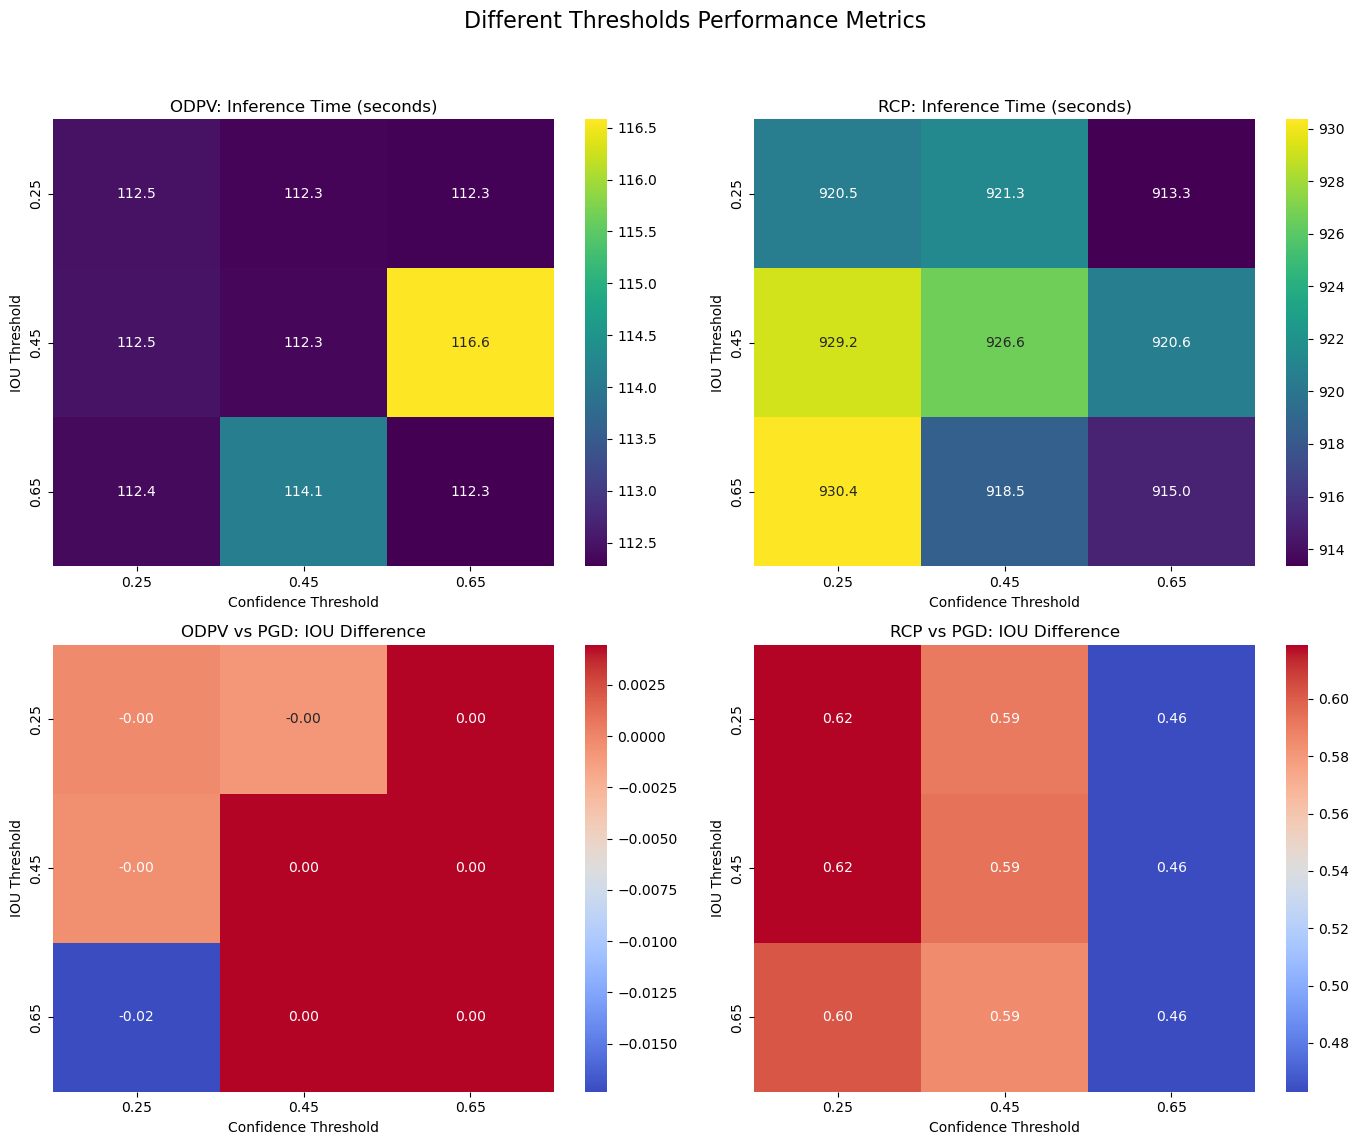

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_visualize_ablation(file_path='../data/origin/ablation.csv'):
    """
    加载、处理消融实验数据，并生成热力图进行可视化。
    此版本会识别并打印出包含非数字/空白数据的行，然后再进行处理。
    """
    try:
        # 1. 加载数据
        print(f"正在从 '{file_path}' 加载数据...")
        df = pd.read_csv(file_path)
        original_rows = len(df)
        print(f"成功加载 {original_rows} 行数据。")

        # 2. --- 新增功能：检查并报告问题行 ---
        # 检查 'iou' 和 'time' 列中哪些值无法转换为数字
        # .isna() 会识别出转换失败后产生的 NaN (Not a Number)
        invalid_mask = pd.to_numeric(df['iou'], errors='coerce').isna() | \
                       pd.to_numeric(df['time'], errors='coerce').isna()
        
        problematic_rows = df[invalid_mask]

        if not problematic_rows.empty:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("注意：在进行计算前，发现了以下包含空白或非数字数据的行。")
            print("这些行将被从分析中排除：")
            print("--------------------------------------------------------------")
            # 使用 to_string() 来确保所有列都被完整显示
            print(problematic_rows.to_string())
            print("--------------------------------------------------------------\n")
        else:
            print("数据检查完毕，未发现空白或非数字的 'iou'/'time' 值。")

        # 3. 强制转换数据类型并移除问题行
        df['iou'] = pd.to_numeric(df['iou'], errors='coerce')
        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        df.dropna(subset=['iou', 'time'], inplace=True)
        
        if len(df) < original_rows:
            print(f"数据清洗后，剩余 {len(df)} 行有效数据用于分析。")

        # 4. 按方法分离数据，并分别计算平均值
        methods_to_analyze = ['odpv', 'rcp', 'pgd']
        aggregated_data = {}

        for method in methods_to_analyze:
            method_df = df[df['method'] == method]
            agg_df = method_df.groupby(['conf_threshold', 'iou_threshold']).agg(
                mean_iou=('iou', 'mean'),
                mean_time=('time', 'mean')
            ).reset_index()
            agg_df.rename(columns={'mean_iou': f'iou_{method}', 'mean_time': f'time_{method}'}, inplace=True)
            aggregated_data[method] = agg_df

        # 5. 合并数据
        # 使用 reduce 来优雅地合并多个 dataframe
        from functools import reduce
        final_df = reduce(lambda left, right: pd.merge(left, right, on=['conf_threshold', 'iou_threshold'], how='outer'), 
                          aggregated_data.values())

        # 6. 计算 IOU 差距
        final_df['iou_diff_odpv'] = final_df['iou_odpv'] - final_df['iou_pgd']
        final_df['iou_diff_rcp'] = final_df['iou_rcp'] - final_df['iou_pgd']

        # 7. 创建用于绘图的透视表并绘图
        print("正在生成热力图...")
        time_odpv_pivot = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='time_odpv')
        time_rcp_pivot = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='time_rcp')
        iou_diff_odpv_pivot = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='iou_diff_odpv')
        iou_diff_rcp_pivot = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='iou_diff_rcp')

        # --- 绘图部分 ---
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        fig.suptitle('Different Thresholds Performance Metrics', fontsize=16)

        sns.heatmap(time_odpv_pivot, ax=axes[0, 0], annot=True, fmt=".1f", cmap="viridis")
        axes[0, 0].set_title('ODPV: Inference Time (seconds)')
        axes[0, 0].set_xlabel('Confidence Threshold')
        axes[0, 0].set_ylabel('IOU Threshold')

        sns.heatmap(time_rcp_pivot, ax=axes[0, 1], annot=True, fmt=".1f", cmap="viridis")
        axes[0, 1].set_title('RCP: Inference Time (seconds)')
        axes[0, 1].set_xlabel('Confidence Threshold')
        axes[0, 1].set_ylabel('IOU Threshold')

        sns.heatmap(iou_diff_odpv_pivot, ax=axes[1, 0], annot=True, fmt=".2f", cmap="coolwarm")
        axes[1, 0].set_title('ODPV vs PGD: IOU Difference')
        axes[1, 0].set_xlabel('Confidence Threshold')
        axes[1, 0].set_ylabel('IOU Threshold')

        sns.heatmap(iou_diff_rcp_pivot, ax=axes[1, 1], annot=True, fmt=".2f", cmap="coolwarm")
        axes[1, 1].set_title('RCP vs PGD: IOU Difference')
        axes[1, 1].set_xlabel('Confidence Threshold')
        axes[1, 1].set_ylabel('IOU Threshold')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        output_filename = 'ablation_study_heatmaps_final.png'
        plt.savefig(output_filename)
        
        print(f"\n成功! 图像已保存为 '{output_filename}'")

    except FileNotFoundError:
        print(f"错误：无法找到 '{file_path}' 文件。请确保它与脚本在同一个目录下。")
    except Exception as e:
        print(f"发生了一个未知错误: {e}")

# --- 主程序入口 ---
if __name__ == '__main__':
    # 将你的CSV文件名放在这里
    process_and_visualize_ablation('../data/origin/ablation.csv')

正在从 '../data/origin/ablation.csv' 加载数据...
成功加载 3744 行数据。
数据检查完毕，未发现空白或非数字的 'iou'/'time' 值。


/var/folders/n7/cqlvwsyx5fq1w3037nvbxyww0000gn/T/ipykernel_13800/1254262470.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])



成功! 图像已保存为 'ablation_study_heatmaps_final.png'


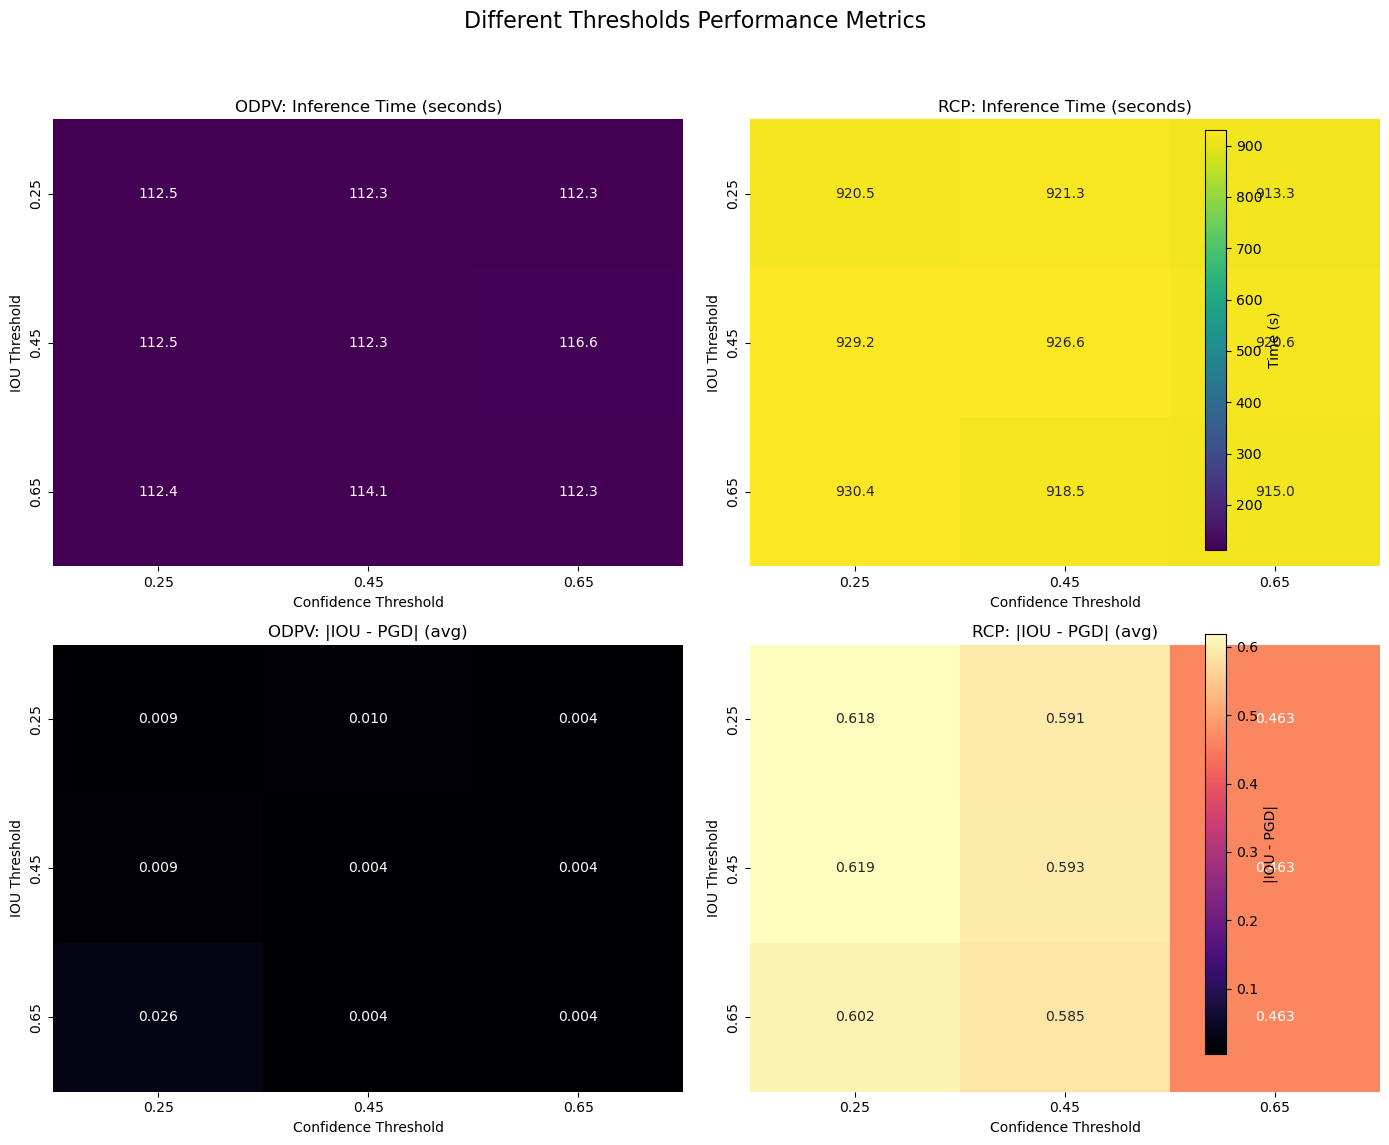

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

def process_and_visualize_ablation(file_path='../data/origin/ablation.csv'):
    """
    加载、处理消融实验数据，并生成热力图进行可视化。
    此版本会识别并打印出包含非数字/空白数据的行，然后再进行处理。
    """
    try:
        # 1. 加载数据
        print(f"正在从 '{file_path}' 加载数据...")
        df = pd.read_csv(file_path)
        original_rows = len(df)
        print(f"成功加载 {original_rows} 行数据。")

        # 2. --- 新增功能：检查并报告问题行 ---
        # 检查 'iou' 和 'time' 列中哪些值无法转换为数字
        # .isna() 会识别出转换失败后产生的 NaN (Not a Number)
        invalid_mask = pd.to_numeric(df['iou'], errors='coerce').isna() | \
                       pd.to_numeric(df['time'], errors='coerce').isna()
        
        problematic_rows = df[invalid_mask]

        if not problematic_rows.empty:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("注意：在进行计算前，发现了以下包含空白或非数字数据的行。")
            print("这些行将被从分析中排除：")
            print("--------------------------------------------------------------")
            # 使用 to_string() 来确保所有列都被完整显示
            print(problematic_rows.to_string())
            print("--------------------------------------------------------------\n")
        else:
            print("数据检查完毕，未发现空白或非数字的 'iou'/'time' 值。")

        # 3. 强制转换数据类型并移除问题行
        df['iou'] = pd.to_numeric(df['iou'], errors='coerce')
        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        df.dropna(subset=['iou', 'time'], inplace=True)
        
        if len(df) < original_rows:
            print(f"数据清洗后，剩余 {len(df)} 行有效数据用于分析。")

        # 4. 按方法分离数据，并分别计算平均值
        methods_to_compare = ['odpv', 'rcp']
        # 需要用于精确匹配 PGD 的键
        match_keys_all = ['model', 'image', 'epsilon', 'gt_index', 'conf_threshold', 'iou_threshold']
        match_keys = [k for k in match_keys_all if k in df.columns]  # 以防某些列缺失

        if len(set(['conf_threshold','iou_threshold']).intersection(df.columns)) < 2:
            raise ValueError("缺少 conf_threshold 或 iou_threshold 列，无法绘制热力图。")

        # PGD 基准
        pgd_cols = match_keys + ['iou']
        pgd_df = df[df['method'] == 'pgd'][pgd_cols].rename(columns={'iou': 'iou_pgd'})

        # 为每个方法与 PGD 对齐，计算 |iou - iou_pgd|，并聚合到 (conf,iou) 栅格
        agg_list = []
        for m in methods_to_compare:
            sub_cols = match_keys + ['iou', 'time']
            sub = df[df['method'] == m][sub_cols].rename(columns={'iou': f'iou_{m}', 'time': f'time_{m}'})
            merged = pd.merge(sub, pgd_df, on=match_keys, how='inner')

            if merged.empty:
                print(f"警告：方法 {m} 与 PGD 在指定键上无可对齐的样本，跳过。")
                continue

            merged[f'abs_gap_{m}'] = (merged[f'iou_{m}'] - merged['iou_pgd']).abs()

            agg = merged.groupby(['conf_threshold', 'iou_threshold']).agg(
                **{f'delta_{m}': (f'abs_gap_{m}', 'mean'),
                   f'time_{m}': (f'time_{m}', 'mean')}
            ).reset_index()
            agg_list.append(agg)

        if not agg_list:
            raise ValueError("没有可用于绘图的聚合结果。")

        # 合并 ODPV 与 RCP 的聚合结果
        from functools import reduce
        final_df = reduce(lambda l, r: pd.merge(l, r, on=['conf_threshold', 'iou_threshold'], how='outer'), agg_list)

        # 5. 创建透视表
        time_odpv_pivot = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='time_odpv')
        time_rcp_pivot  = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='time_rcp')
        delta_odpv_pivot = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='delta_odpv')
        delta_rcp_pivot  = final_df.pivot_table(index='iou_threshold', columns='conf_threshold', values='delta_rcp')

        # 6. 绘图（两组图分别共享颜色映射与公共 colorbar）
        import matplotlib as mpl
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        fig.suptitle('Different Thresholds Performance Metrics', fontsize=16)

        # 共享 time 颜色映射
        time_all = np.concatenate([
            time_odpv_pivot.values.ravel(),
            time_rcp_pivot.values.ravel()
        ])
        vmin_time = np.nanmin(time_all)
        vmax_time = np.nanmax(time_all)
        norm_time = mpl.colors.Normalize(vmin=vmin_time, vmax=vmax_time)

        im_time_odpv = sns.heatmap(time_odpv_pivot, ax=axes[0, 0], annot=True, fmt=".1f",
                                   cmap="viridis", norm=norm_time, cbar=False)
        axes[0, 0].set_title('ODPV: Inference Time (seconds)')
        axes[0, 0].set_xlabel('Confidence Threshold')
        axes[0, 0].set_ylabel('IOU Threshold')

        im_time_rcp = sns.heatmap(time_rcp_pivot, ax=axes[0, 1], annot=True, fmt=".1f",
                                  cmap="viridis", norm=norm_time, cbar=False)
        axes[0, 1].set_title('RCP: Inference Time (seconds)')
        axes[0, 1].set_xlabel('Confidence Threshold')
        axes[0, 1].set_ylabel('IOU Threshold')

        cbar_time = fig.colorbar(axes[0, 0].collections[0],
                                 ax=[axes[0, 0], axes[0, 1]],
                                 orientation='vertical', fraction=0.046, pad=0.04)
        cbar_time.set_label('Time (s)')

        # 共享 |IOU - PGD| 颜色映射（非负，用顺序色图）
        delta_all = np.concatenate([
            delta_odpv_pivot.values.ravel(),
            delta_rcp_pivot.values.ravel()
        ])
        vmin_delta = np.nanmin(delta_all)
        vmax_delta = np.nanmax(delta_all)
        norm_delta = mpl.colors.Normalize(vmin=vmin_delta, vmax=vmax_delta)

        im_delta_odpv = sns.heatmap(delta_odpv_pivot, ax=axes[1, 0], annot=True, fmt=".3f",
                                    cmap="magma", norm=norm_delta, cbar=False)
        axes[1, 0].set_title('ODPV: |IOU - PGD| (avg)')
        axes[1, 0].set_xlabel('Confidence Threshold')
        axes[1, 0].set_ylabel('IOU Threshold')

        im_delta_rcp = sns.heatmap(delta_rcp_pivot, ax=axes[1, 1], annot=True, fmt=".3f",
                                   cmap="magma", norm=norm_delta, cbar=False)
        axes[1, 1].set_title('RCP: |IOU - PGD| (avg)')
        axes[1, 1].set_xlabel('Confidence Threshold')
        axes[1, 1].set_ylabel('IOU Threshold')

        cbar_delta = fig.colorbar(axes[1, 0].collections[0],
                                  ax=[axes[1, 0], axes[1, 1]],
                                  orientation='vertical', fraction=0.046, pad=0.04)
        cbar_delta.set_label('|IOU - PGD|')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        output_filename = 'ablation_study_heatmaps_final.png'
        plt.savefig(output_filename)
        print(f"\n成功! 图像已保存为 '{output_filename}'")

    except FileNotFoundError:
        print(f"错误：无法找到 '{file_path}' 文件。请确保它与脚本在同一个目录下。")
    except Exception as e:
        print(f"发生了一个未知错误: {e}")

# --- 主程序入口 ---
if __name__ == '__main__':
    # 将你的CSV文件名放在这里
    process_and_visualize_ablation('../data/origin/ablation.csv')

In [2]:
import pandas as pd

def compute_iou_diffs(df: pd.DataFrame, keys=None) -> pd.DataFrame:
    """
    计算 ODPV、RCP 相对 PGD 的 iou_0.5 和 iou_0.7 差值，并标记各方法是否 (iou_0.5 == 0 且 iou_0.7 == 0)。

    参数
    - df: 包含列 ['method', 'iou_0.5', 'iou_0.7'] 的 DataFrame。method 至少包含 'pgd', 'odpv', 'rcp'。
    - keys: 用于对齐同一实验的键列列表（如 ['dataset', 'model']）。默认自动推断为除
            ['method','iou_0.5','iou_0.7'] 之外的所有列。

    返回
    - DataFrame：按 keys 聚合后的宽表，包含差值与布尔标记列。
    """
    required = {'method', 'iou_0.5', 'iou_0.7'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"缺少必要列: {missing}")

    # 复制并标准化 method 为小写，避免大小写问题
    df = df.copy()
    df['method'] = df['method'].astype(str).str.lower()

    if keys is None:
        keys = [c for c in df.columns if c not in ['method', 'iou_0.5', 'iou_0.7']]

    # 透视为宽表：行 = keys 组合，列 = (metric, method)
    pivot = df.pivot_table(
        index=keys,
        columns='method',
        values=['iou_0.5', 'iou_0.7'],
        aggfunc='first'  # 如果同一(keys, method)有多条记录，这里取第一条
    )

    # 扁平化多级列名，如 ('iou_0.5','pgd') -> 'iou_0.5_pgd'
    pivot.columns = [f'{metric}_{method}' for metric, method in pivot.columns]

    # 确保缺失的方法列存在，便于计算（用 NA 占位）
    for thr in ['iou_0.5', 'iou_0.7']:
        for m in ['pgd', 'odpv', 'rcp']:
            col = f'{thr}_{m}'
            if col not in pivot.columns:
                pivot[col] = pd.NA

    # 差值：方法 - PGD
    pivot['diff_iou_0.5_odpv_minus_pgd'] = pivot['iou_0.5_odpv'] - pivot['iou_0.5_pgd']
    pivot['diff_iou_0.7_odpv_minus_pgd'] = pivot['iou_0.7_odpv'] - pivot['iou_0.7_pgd']
    pivot['diff_iou_0.5_rcp_minus_pgd']  = pivot['iou_0.5_rcp']  - pivot['iou_0.5_pgd']
    pivot['diff_iou_0.7_rcp_minus_pgd']  = pivot['iou_0.7_rcp']  - pivot['iou_0.7_pgd']

    # 各方法是否 (iou_0.5 == 0 且 iou_0.7 == 0)
    pivot['both_zero_odpv'] = (pivot['iou_0.5_odpv'] == 0) & (pivot['iou_0.7_odpv'] == 0)
    pivot['both_zero_rcp']  = (pivot['iou_0.5_rcp']  == 0) & (pivot['iou_0.7_rcp']  == 0)
    pivot['both_zero_pgd']  = (pivot['iou_0.5_pgd']  == 0) & (pivot['iou_0.7_pgd']  == 0)

    return pivot.reset_index()
result_file = data_dir / "ablation.csv"
print(compute_iou_diffs(pd.read_csv(result_file)))

NameError: name 'data_dir' is not defined